# Tittle: Identification of Marker Genes in Human Breast Tumors using scRNA 
# Introduction

Tamoxifen is a selective estrogen receptor modulator (SERM) medication used to treat breast cancer. breast cancer is a major type of cancer in females. Detecting cancer early poses a significant challenge due to its inherent heterogeneity. In ER-positive, HER2-negative breast cancer, multiple measures of intra-tumor heterogeneity are associated with worse response to endocrine therapy

Recent progress in next-generation technologies has facilitated the exploration of novel gene expressions involved in breast cancer pathogenesis. Using Next-Generation Sequencing (NGS) methods has generated extensive datasets, necessitating computationally intensive analyses. 
# Research Questions
In this project, we leverage a single-cell-RNA dataset  to identify: 
1. Which genes are differentially expressed in breat cancer?
2. Which genes are co-expressed in breast cancer?
3. What is the expression pattern of differentially expressed genes per cell type?
4. Which pathways are enriched in different cell types in breast cancer?

# Dataset

The dataset under consideration comprises samples from the population of live human tumors and normal breast specimens tha were taken immediately after surgical resection for processing into single-cell workflows for experimentation and genomic analyses.I this study, we show differences in tamoxifen response by cell type. The data set was obtained from NCBI GEO database under the accession number GSE245601

# Methodology
- Data Acqusition: h5 format
- Preprocessing and Quality control: Gene, cell and mitochondria filtering
- Clustering: UMAP
- Data Visualization: Dot plots,violin, track plots,scatter plots, heatmaps
- Benchmarking: Literature Search

In [49]:
# ignore warnings and standasrd outputs
# Filtering warnings from current version of matplotlib
import warnings

warnings.filterwarnings(
    "ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message="Tight layout not applied.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message=" invalid value encountered in log2", category=RuntimeWarning
)

# Workflow

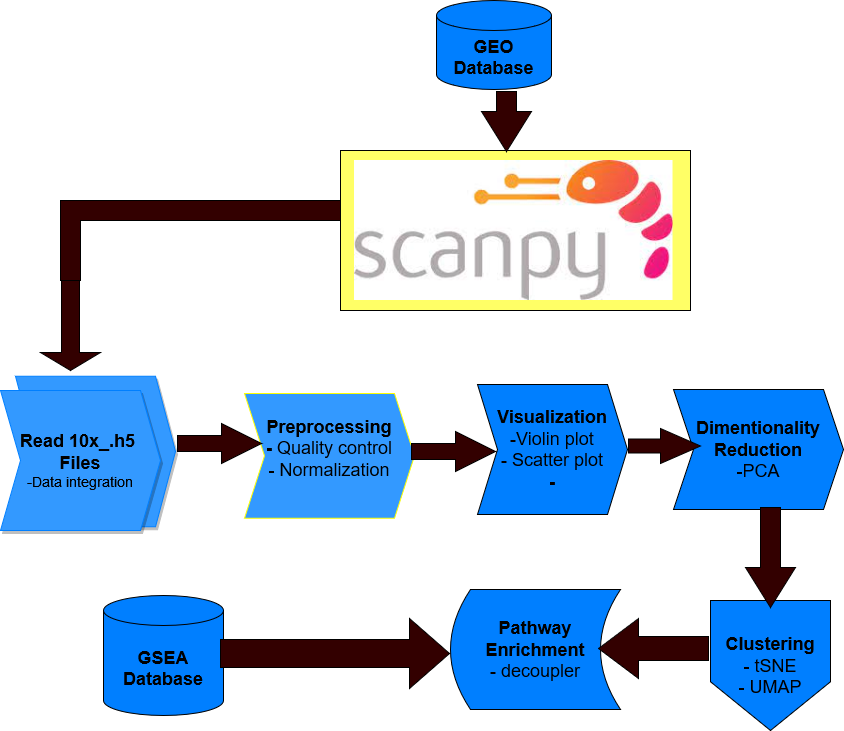

In [2]:
from IPython.display import Image, display

# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = 'new_workflow.png'

# Display the image
display(Image(filename=image_path))


# Data Acquisition
The datset was downloaded using ftp commandline as follows
Counts data

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

The counts data represent the number of RNA sequencing reads that have been aligned to each gene in the transcriptome. These counts can be indicative of the level of gene expression in the samples. The file contains gene expression data in the form of counts, derived from RNA sequencing experiments. 

Normalized counts data
! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

This file likely contains normalized gene expression data from the same RNA sequencing experiments.
Normalization is a process used to adjust for technical variations between samples, allowing for more accurate comparisons of gene expression levels across different experimental conditions or samples. For this work, we used a subdataset for normal and tumor cells as shown in the list of files. The hashed file were not used in this work.

# Scanpy set up and loading required libraries

In [2]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import scipy
import scipy.io as sio
import pandas as pd
import warnings
import decoupler 
import seaborn.objects as so
warnings.simplefilter(action='ignore', category=FutureWarning)# supress some warnings
sc.settings.verbosity = 3

# Data integration
The data was in multiple .h5 files. We used a function to merge the different files into a single file

In [1]:
import h5py
import os
# output_file = "output.h5"
folder_path = "../data/"

# Get a list of H5 files in the folder
adatas = []
# d_names = ["../data/"+f for f in os.listdir(folder_path) if f.endswith('.h5')]


d_names = [
'GSM7845546_Normal_01_Control.h5',
'GSM7845548_Normal_02_Control.h5',
# 'GSM7845550_T47D_Control.h5',
'GSM7845552_Tumor_01_Control.h5',
'GSM7845554_Tumor_02_Control.h5',
'GSM7845556_Tumor_03_Control.h5',
'GSM7845558_Tumor_04_Control.h5',
# 'GSM7845560_Tumor_05_Control.h5',
# 'GSM7845562_Tumor_06_Control.h5',
# 'GSM7845564_Tumor_07_Control.h5',
'GSM7845566_Tumor_08_Control.h5',
# 'GSM7845568_Tumor_09_Control.h5',
# 'GSM7845570_Tumor_10_Control.h5'
]
for filename in d_names: 
    adata = sc.read_10x_h5('../data/'+filename) 
    adata.var_names_make_unique() 
    adatas.append(adata) 
adata = adatas[0].concatenate(adatas[1:])
# Save the concatenated AnnData object to an HDF5 file
output_h5_file = "../data/merged.h5"  # Adjust the output file name
adata.write(output_h5_file)

In [40]:
data= sc.read_h5ad("../data/merged.h5")

In [41]:
data

AnnData object with n_obs × n_vars = 39591 × 33538
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

# Now we will check the  number of cells and number of genes

In [42]:
print(f"The number of genes are: {data.n_obs}")
print(f"The number of cells are: {data.n_vars}")

The number of genes are: 39591
The number of cells are: 33538


In [43]:
data.obs

batch
AAACCCAAGTCAGGGT-1-0     0
AAACCCACATCACAGT-1-0     0
AAACCCATCTCAATCT-1-0     0
AAACGAACAAGTTCGT-1-0     0
AAACGAACACAACGAG-1-0     0
...                    ...
TTTGATCTCTAGACAC-1-6     6
TTTGGTTGTTCCTAAG-1-6     6
TTTGTTGAGGGCATGT-1-6     6
TTTGTTGAGGTAATCA-1-6     6
TTTGTTGGTCCGGACT-1-6     6

[39591 rows x 1 columns]

In [49]:
#Get a list of H5 files in the folder in a specific order
#Initialize a list to store labels based on the file names
labels = []
# Dictionary to store the number of observations in each file
observations_count = {}

# Iterate over H5 files and get the number of observations
for i in d_names:
    path = os.path.join(folder_path, i)    
    # # Read AnnData object using Scanpy
    adata = sc.read_10x_h5(path)
    # # Get the number of observations
    num_observations = adata.n_obs 
    # print(num_observations)
    observations_count[i] = num_observations
    # # Determine label based on file name
    label = "Normal" if "Normal" in i else "Tumor"
    # # Repeat the label for the corresponding number of observations
    labels.extend([label] * num_observations)

In [45]:
# Save the modified AnnData with lables in HDF5 format)
output_file = '../data/modified_data.h5ad'
data.write(output_file)

In [46]:
# Read the file 
data= sc.read_h5ad("../data/merged.h5")

In [47]:
# Add labels to the concatenated AnnData object
data.obs['label'] = labels

In [48]:
data.obs

batch   label
AAACCCAAGTCAGGGT-1-0     0  Normal
AAACCCACATCACAGT-1-0     0  Normal
AAACCCATCTCAATCT-1-0     0  Normal
AAACGAACAAGTTCGT-1-0     0  Normal
AAACGAACACAACGAG-1-0     0  Normal
...                    ...     ...
TTTGATCTCTAGACAC-1-6     6   Tumor
TTTGGTTGTTCCTAAG-1-6     6   Tumor
TTTGTTGAGGGCATGT-1-6     6   Tumor
TTTGTTGAGGTAATCA-1-6     6   Tumor
TTTGTTGGTCCGGACT-1-6     6   Tumor

[39591 rows x 2 columns]

The dataset has 39591 genes

# Data Wrangling/ Exploratory Data Analysis
In this section, we will answer below questions
- How many genes are in the raw count dataset?
- How many cells?
- Are there mitochondria contaminants?
- Which genes are highly expressed?


Number of cells (observations or n_obs): 4267

Number of genes (variables or n_vars): 33538

In [50]:
# data
#check total number of mitochondrial genes in the dataset
data.var_names.str.contains("MT-").sum()

14

In [51]:
 # annotate the group of mitochondrial genes as 'MT'
data.var['mt'] = data.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [52]:
# check the genes and count statistics 
data.var

gene_ids    feature_types  genome     mt  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False   
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False   
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False   
...                      ...              ...     ...    ...   
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False   
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False   
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False   
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False   
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False   

             n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
MIR1302-2HG                  1     0.000025              99.997474   
FAM138A                      0     0.000000             100.000000   
OR4F5                        6     0.000152              99.984845   
AL627309.1                 112     0.002829              99.717107   
AL627309.3                  18     0.000455              99.954535   
...                        ...          ...                    ...   
AC233755.2                   5     0.000126              99.987371   
AC233755.1                   2     0.000126              99.994948   
AC240274.1                1693     0.056907              95.723776   
AC213203.1                   0     0.000000             100.000000   
FAM231C                      0     0.000000             100.000000   

             total_counts  
MIR1302-2HG           1.0  
FAM138A               0.0  
OR4F5                 6.0  
AL627309.1          112.0  
AL627309.3           18.0  
...                   ...  
AC233755.2            5.0  
AC233755.1            5.0  
AC240274.1         2253.0  
AC213203.1            0.0  
FAM231C               0.0  

[33538 rows x 8 columns]

In [53]:
#make the gene names unique
data.var_names_make_unique()

# Quality Control and Filtering
- Mitochondrial gene composition.
Mitochondrial genes often start with "MT-" or "MTRNR," and their inclusion helps estimate the mitochondrial composition of each cell. Most of the cells have a mitochondria count percentage below 15%. The cells with higher than 15% mitochondria count may signify cell stress and damage and were therefore filterd out.
- Cell counts. Cells with less than 500 genes were excluded from downstream analysis. The low gene count in cells can be due to low capture, inefficient cell lysis or non-viable cells.
Each violin plot represents the distribution of the number of genes expressed per cell.
- Gene counts
- Cells with less than 20000 total count were excluded from the analysis.


## Violin Plot

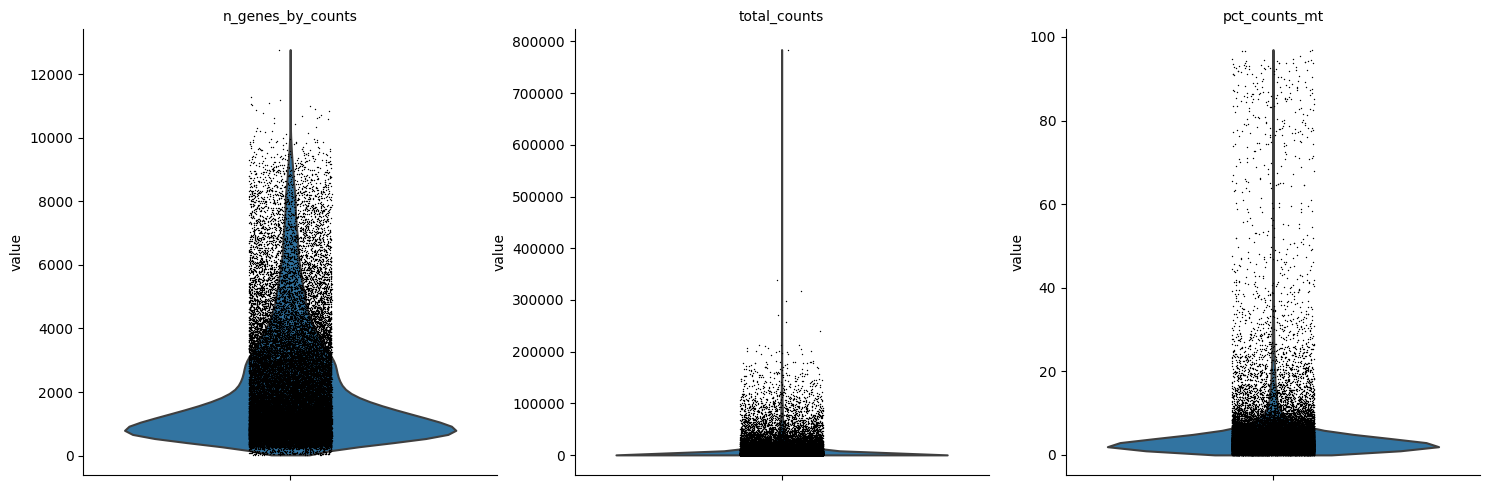

In [54]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_mt'
     ],
    multi_panel=True,
    # save='_gene_MT_vs_transcript_counts',
);

## Scatter Plots

The plots indicate that some reads have a relatively high percentage of mitochondrial counts which are often associated with cell degradation. However, most of the cells have less than 15% mitochondria percentage which. We can also observe most cells have total counts of below 20000. For gene counts per cell, most cells approximately contain about 5000 gene counts on average. These visualizations were used to set the quality control thresholds. We also filter out genes that are not detected in at least 20 cells as these are not informative.

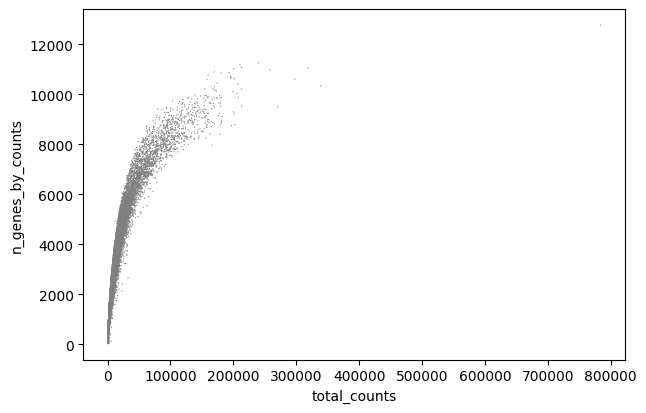

In [55]:
sc.pl.scatter(data, "total_counts", "n_genes_by_counts")

The scatter plot shows gene counts per each gene. The output shows presence of potential outliers for gene counts

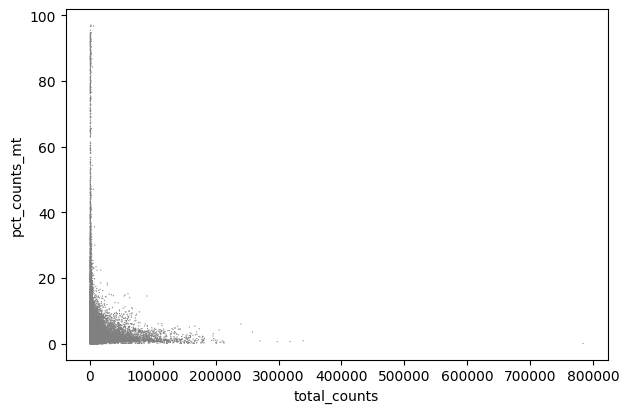

In [56]:
sc.pl.scatter(data, "total_counts", "pct_counts_mt")

From the scatter plot, few cells have mitochondria composition above 15% which is the desirable threshold. We will filter cells with a percentage count above 15% mitochondria count

In [57]:
# Filter the data
data = data[data.obs.n_genes_by_counts < 5000,:]
data = data[data.obs.total_counts < 20000,:]
data = data[data.obs.pct_counts_mt < 15,:]
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(data, min_cells=20)
data.shape # Checking number of cells remaining

filtered out 13761 genes that are detected in less than 20 cells


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


(33434, 19777)

We have filtered cells with less than 500 genes, cells with less than 20000 total count and cells with more than 15% mitochondrial gene composition and genes that are only present in 20 cells or less.

## Violin plots after QC

After filtering, the number of genes remaining is 2972 and the number of cells remainaing is 33538

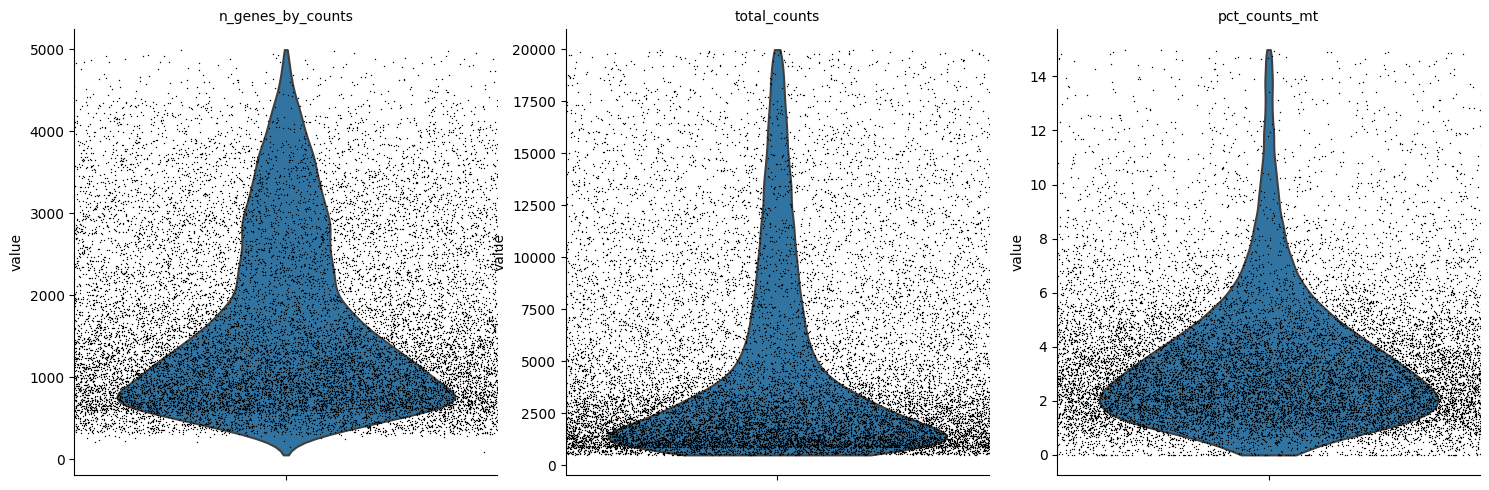

In [52]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_mt'
     ],
    jitter=1,
    multi_panel=True,
    # save='Filtered_gene_MT_vs_transcript_counts'
   
)


After the quality control, we can see the interquartile ranges for gene counts, total counts and mitochondria composition are within the expected ranges based on the previous filtered parameters. 

## Scatter plot after QC

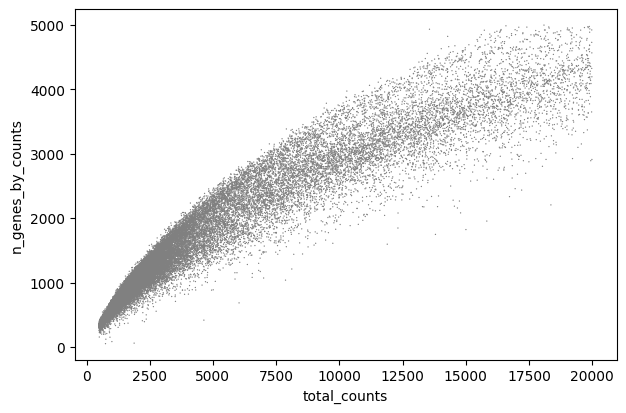

In [53]:
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

The scatter plot shows the distribution of the number of gene counts. We can see the gene counts increase with the increase in total counts for the genes. The plot also shows the presence of potential outliers in some gene counts. Before filtering, we can normalize the counts and visualize nwe the distribution.

# Normalization
This step is performed to account for technical biases and variability across cells, ensuring that the observed differences in gene expression are reflective of biological signals rather than technical artifacts. For example
- Each cell in a scRNA-seq experiment may have a different number of RNA molecules, resulting in variability in library sizes
-  samples are processed at different times, and batch effects can introduce unwanted variability.
-   Longer genes generally produce more sequencing reads, and some cells may be sequenced more deeply than others.
-   Technical variations such as amplification bias, and sequencing biases
  
In this project, transcripts per million (TPm) normalization and log normalization have been used. The log normalization was adopted since scRNA has high variance.

In [59]:
#normarization
data.layers["counts"] = data.X.copy() # preserve counts
sc.pp.normalize_total(data, target_sum=1e6) # scale each cell to a common library size
sc.pp.log1p(data) # log(expression + 1)
data.raw = data # freeze the state in `.raw`

normalizing counts per cell
    finished (0:00:00)


## Gene counts after QC and Normalization

In [60]:
print("min_gene count is ", data.obs["n_genes_by_counts"].min(), "\n max_gene count is ",data.obs["n_genes_by_counts"].max())

min_gene count is  50 
 max_gene count is  4992


In [61]:
data.obs["n_genes_by_counts"].max()

4992

# Highly variable genes
Discarding non-significant genes that are equally expressed across the cells is a preprocessing step in scRNA-seq analysis. This process is performed to reduce noise, to focus on the most informative genes, and improve the efficiency of downstream analyses. After extracting highly variable genes, we see that only 6684 genes remained for downstream analysis.

extracting highly variable genes
    finished (0:00:17)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


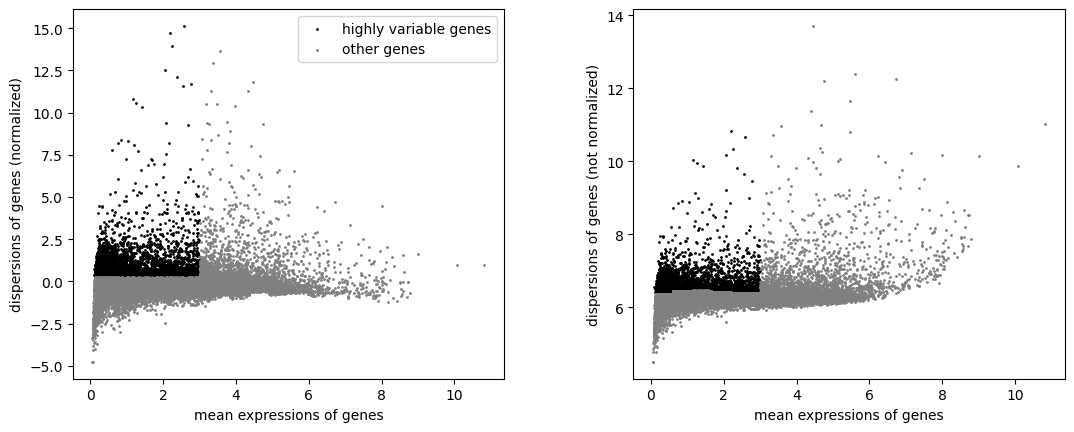

In [62]:
#determining High variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(data) 

The plots show that before normalization, the dispersion of genes have wide range from 2 to 14. Aftwr bnormalization, there is positive and negative dispersion ranging from -5 to 15. Genes with a mean expression below 0.25 dispersion  threshold were excluded from consideration as highly variable genes

In [63]:
data.raw=data
data = data[:, data.var['highly_variable']]
sc.pp.scale(data, zero_center=True, max_value=3)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [60]:
print("min_nom",data.var["dispersions_norm"].min(),"\nmax_norm is",data.var["dispersions_norm"].max())

min_nom 0.25004742 
max_norm is 15.131056


normalizing counts per cell


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:01)


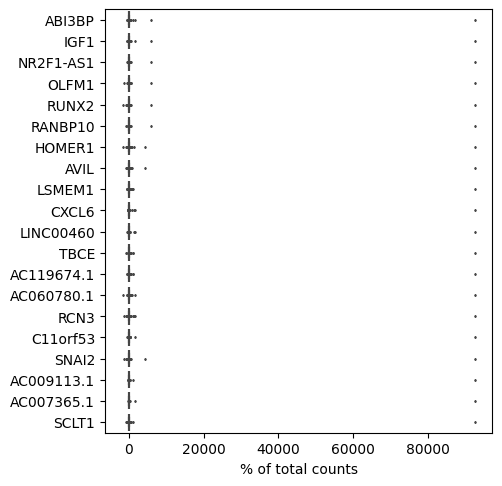

In [61]:
sc.pl.highest_expr_genes(data, n_top=20)

# Dimentinality Reduction -PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:47)


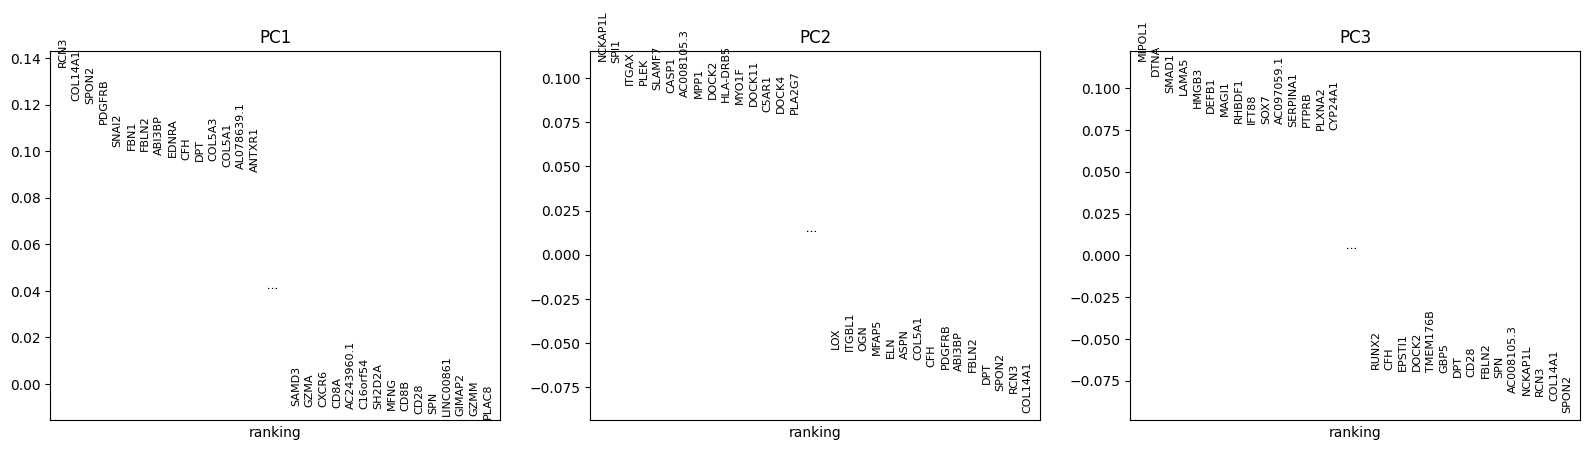

In [62]:
# Perform PCA
sc.tl.pca(data)
# Visualize PCA loadings
sc.pl.pca_loadings(data, show=True)  #

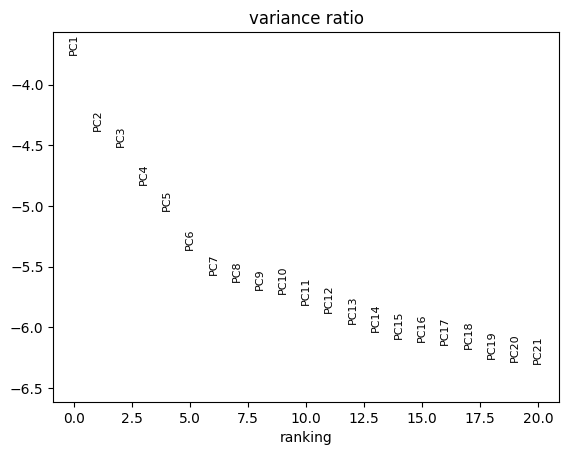

In [63]:
# Visualize PCA variance ratio to get the optimal PCA
sc.pl.pca_variance_ratio(data, n_pcs=20, log=True, show=True)

 Now let us  plit PCA with 8 PCAs


computing PCA
    on highly variable genes
    with n_comps=8
    finished (0:00:12)


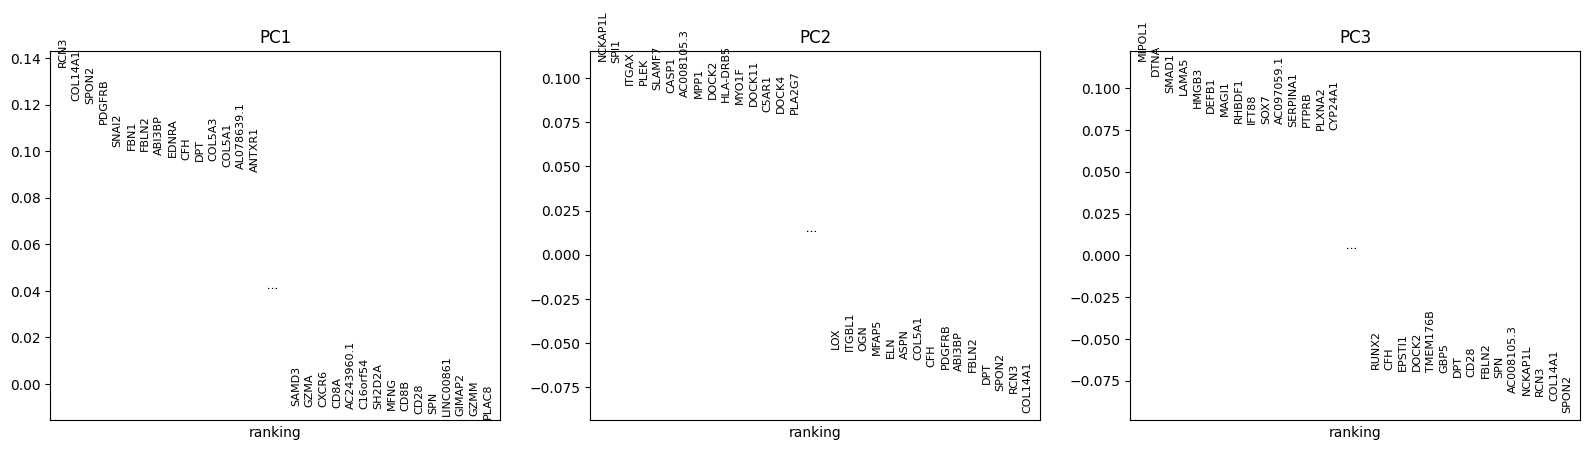

In [64]:
# Perform PCA
sc.tl.pca(data,n_comps=8)
# Visualize PCA loadings
sc.pl.pca_loadings(data, show=True)  #

From the PCA results, we can see that gene RCN3 is the most differentially expressed in the cells for PC1. Other genes such as PLAC8 contribute to the observed variation in the expression patterns for PCA1. In PC2, the NCKAP1L gene contributes most to the observed gene expression patterns in the gene expressions within the cells. Some genes such as COL14A1 seem to be very lowly expressed (negative variation) in most of the cells and it contributes to the variation in gene expression patterns for PC2. For PC3, the gene MPOL1 was shown to be upregulated in some cells causing the variation in the expression patterns whereas gene SPNON2 seems to be underexpressed among the cell types. These genes can therefore be potential biomarkers for breast cancer disease. The number of PCA to use varies with the sample and optimal PCA should be determined for optimal variation in the samples. We can extract the contribution of each PCA and accumulated variance and pick the optimal at the elbow position of th plot as shown in the next figure. The optimal PCAs are  9. 

We will pick number of components to be 8 as this is the optimal PCS from the output of the PCs tested. Only PC1 has positive positive loadings indicating higher expression levels of those genes contribute to higher values of that PC. The remaininng PCs suggest that lower expression levels of those genes contribute to higher values of that PC.

# Clustering
We will use UMAP and tSNE clustering and 8 PCAs already determined
We will pick number of components to be 8 as this is the optimal PCS from the output of the PCs tested. Only PC1 has positive positive loadings indicating higher expression levels of those genes contribute to higher values of that PC. The remaininng PCs suggest that lower expression levels of those genes contribute to higher values of that PC.


## UMAP clustering

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:31)


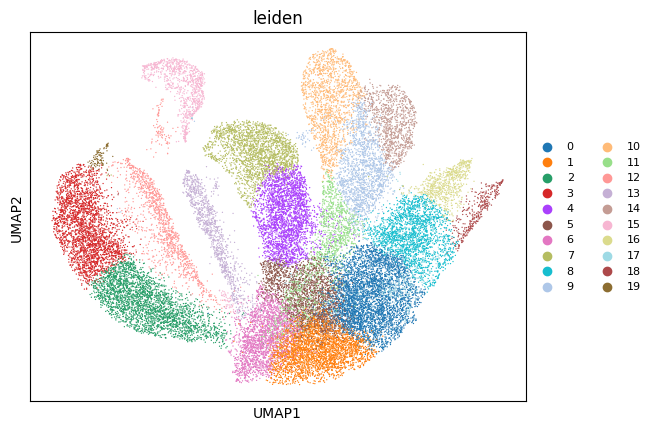

In [67]:
sc.pp.neighbors(data,n_pcs=8)
sc.tl.umap(data)
# perform leiden
#perform laiden on the data
sc.tl.leiden(data)
# sc.tl.leiden(data, key_added="clusters")
sc.pl.umap(data, color=['leiden'], legend_fontsize=8)

# tSNE clustering

computing tSNE
    using 'X_pca' with n_pcs = 8
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:03:30)


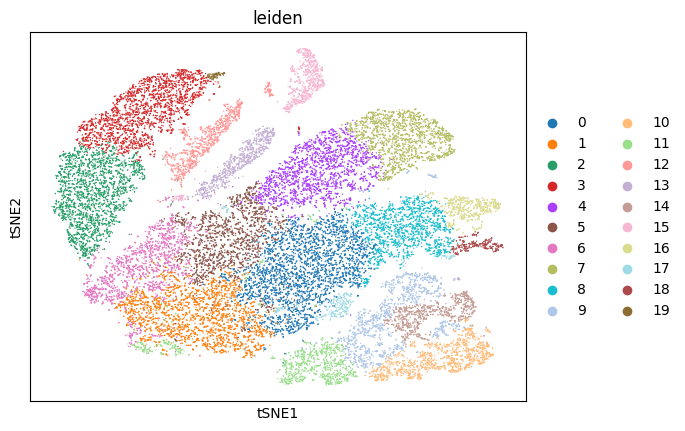

In [68]:
# Embeddings'
# Perform t-SNE
sc.tl.tsne(data,n_pcs=8)
## tSNE
sc.pl.tsne(data, color='leiden')

We can see 19 distinct clusets for the cell types after tSNE. t-SNE is a nonlinear dimensionality reduction technique commonly used for visualizing high-dimensional data in two or three dimensions. It emphasizes the preservation of local structures, making it well-suited for revealing clusters or groups of cells with similar gene expression profiles.

Now we will change the index to the newly asigned labels

tSNE clustering shows there are 19  cell clusters

# Cell Type Identification

To annotate single cell clusters, we can use cell type specific marker genes. These are genes that are mainly expressed exclusively by a specific cell type, making them useful to distinguish heterogeneous groups of cells. Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.


##  Use of PanglaoDB Database for Cell type identification
Omnipath is one of the largest available databases of curated prior knowledge. Among its resources, there is PanglaoDB, a database of cell type markers, which can be easily accessed using a wrapper to Omnipath from decoupler.

In [ ]:
# Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
data.raw = data
data = data[:, data.var.highly_variable]
# Regress and scale the data
sc.pp.regress_out(data, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(data, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


In [18]:
# Query Omnipath and get PanglaoDB
markers = decoupler.get_resource('PanglaoDB')
markers

  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 467, in _make_request
    self._validate_conn(conn)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 1092, in _validate_conn
    conn.connect()
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 642, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 783, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/ssl_.py", line 469, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(sock, context, tls_in_tls, server_hostname)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/ssl_.py", line 513, in _ssl_wrap_socket_impl
    return ssl_context.wrap_socket(sock, server_hostname=server_hostname)
  File "/usr/lib/python3.10/ssl.py", line 513, in wrap_socket
    return se

genesymbol canonical_marker          cell_type germ_layer human  \
0         CTRB1            False        Enterocytes   Endoderm  True   
1         CTRB1             True       Acinar cells   Endoderm  True   
2          KLK1             True  Endothelial cells   Mesoderm  True   
3          KLK1            False       Goblet cells   Endoderm  True   
4          KLK1            False   Epithelial cells   Mesoderm  True   
...         ...              ...                ...        ...   ...   
8456    SLC14A1             True   Urothelial cells   Mesoderm  True   
8457      UPK3A             True   Urothelial cells   Mesoderm  True   
8458      UPK1A             True   Urothelial cells   Mesoderm  True   
8459       UPK2             True   Urothelial cells   Mesoderm  True   
8460      UPK3B             True   Urothelial cells   Mesoderm  True   

     human_sensitivity human_specificity mouse mouse_sensitivity  \
0                  0.0        0.00439422  True        0.00331126   
1                  1.0       0.000628931  True          0.957143   
2                  0.0        0.00841969  True               0.0   
3             0.588235        0.00503937  True          0.903226   
4                  0.0        0.00823306  True          0.225806   
...                ...               ...   ...               ...   
8456               0.0         0.0181704  True               0.0   
8457               0.0               0.0  True               0.0   
8458               0.0               0.0  True               0.0   
8459               0.0               0.0  True               0.0   
8460               0.0               0.0  True               0.0   

     mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0            0.0204803        9606         GI tract           0.017  
1            0.0159201        9606         Pancreas           0.017  
2            0.0149153        9606      Vasculature           0.013  
3            0.0124084        9606         GI tract           0.013  
4            0.0137585        9606       Epithelium           0.013  
...                ...         ...              ...             ...  
8456               0.0        9606  Urinary bladder           0.008  
8457               0.0        9606  Urinary bladder             0.0  
8458               0.0        9606  Urinary bladder             0.0  
8459               0.0        9606  Urinary bladder             0.0  
8460               0.0        9606  Urinary bladder             0.0  

[8461 rows x 13 columns]

Since our data-set is from human cells, and we want best quality of the markers, we can filter by canonical_marker and human:

In [71]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

genesymbol canonical_marker                     cell_type germ_layer  \
1         CTRB1             True                  Acinar cells   Endoderm   
2          KLK1             True             Endothelial cells   Mesoderm   
5          KLK1             True               Principal cells   Mesoderm   
6          KLK1             True                  Acinar cells   Endoderm   
7          KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
...         ...              ...                           ...        ...   
8456    SLC14A1             True              Urothelial cells   Mesoderm   
8457      UPK3A             True              Urothelial cells   Mesoderm   
8458      UPK1A             True              Urothelial cells   Mesoderm   
8459       UPK2             True              Urothelial cells   Mesoderm   
8460      UPK3B             True              Urothelial cells   Mesoderm   

     human human_sensitivity human_specificity mouse mouse_sensitivity  \
1     True               1.0       0.000628931  True          0.957143   
2     True               0.0        0.00841969  True               0.0   
5     True               0.0        0.00814536  True          0.285714   
6     True          0.833333        0.00503145  True          0.314286   
7     True               0.0        0.00820189  True               1.0   
...    ...               ...               ...   ...               ...   
8456  True               0.0         0.0181704  True               0.0   
8457  True               0.0               0.0  True               0.0   
8458  True               0.0               0.0  True               0.0   
8459  True               0.0               0.0  True               0.0   
8460  True               0.0               0.0  True               0.0   

     mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1            0.0159201        9606         Pancreas           0.017  
2            0.0149153        9606      Vasculature           0.013  
5            0.0140583        9606           Kidney           0.013  
6            0.0128263        9606         Pancreas           0.013  
7            0.0129136        9606    Immune system           0.013  
...                ...         ...              ...             ...  
8456               0.0        9606  Urinary bladder           0.008  
8457               0.0        9606  Urinary bladder             0.0  
8458               0.0        9606  Urinary bladder             0.0  
8459               0.0        9606  Urinary bladder             0.0  
8460               0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [72]:
decoupler.run_ora(
    mat=data,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True
)

Running ora on mat with 33434 samples and 3987 targets for 94 sources.


100%|████████████████████████████████████████████████████████████████████████████████| 33434/33434 [01:07<00:00, 496.86it/s]


In [73]:
acts = decoupler.get_acts(data, obsm_key='ora_estimate')
# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e
acts

AnnData object with n_obs × n_vars = 33434 × 94
    obs: 'batch', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'clusters', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'ora_estimate', 'ora_pvals'

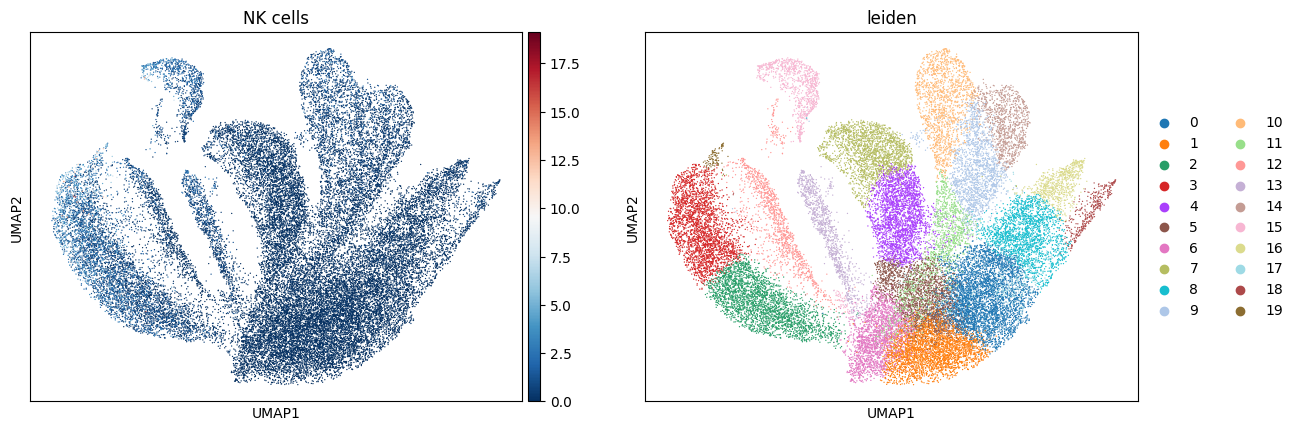

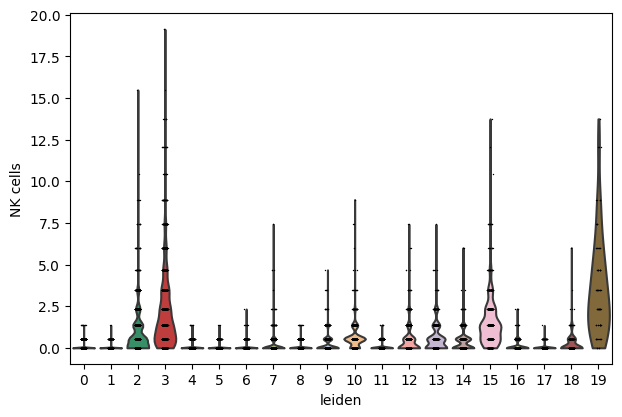

In [74]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

In [75]:
df = decoupler.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

group reference                             names  statistic  meanchange  \
0        0      rest                  Oligodendrocytes  30.892700    0.368305   
1        0      rest                       Clara cells  28.867085    0.372333   
2        0      rest  Pulmonary alveolar type II cells  23.678137    0.256758   
3        0      rest                         Sebocytes  22.394508    0.347455   
4        0      rest                      Interneurons  19.294218    0.179460   
...    ...       ...                               ...        ...         ...   
1875     9      rest                        Thymocytes  -8.899645   -0.132520   
1876     9      rest                           B cells  -9.578164   -0.227496   
1877     9      rest                  Oligodendrocytes -12.640900   -0.268473   
1878     9      rest                       Clara cells -12.776361   -0.355324   
1879     9      rest                      Pinealocytes -25.930250   -0.401406   

              pvals      pvals_adj  
0     1.554620e-197  1.461343e-195  
1     1.854478e-170  8.716047e-169  
2     3.423798e-119  1.072790e-117  
3     1.112190e-107  1.742430e-106  
4      4.637278e-81   5.448802e-80  
...             ...            ...  
1875   1.165827e-18   3.913848e-18  
1876   3.005395e-21   1.228292e-20  
1877   8.593086e-36   6.213462e-35  
1878   1.760840e-36   1.379325e-35  
1879  2.137114e-127  2.008888e-125  

[1880 rows x 7 columns]

In [76]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
# ctypes_dict

In [ ]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

## Cell Type Annotation
 We are going to use automatic prediction by assigning the top predicted cell type per cluster. However, manual inspection of each cell type gene expression require expertise to minimize errors

In [ ]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

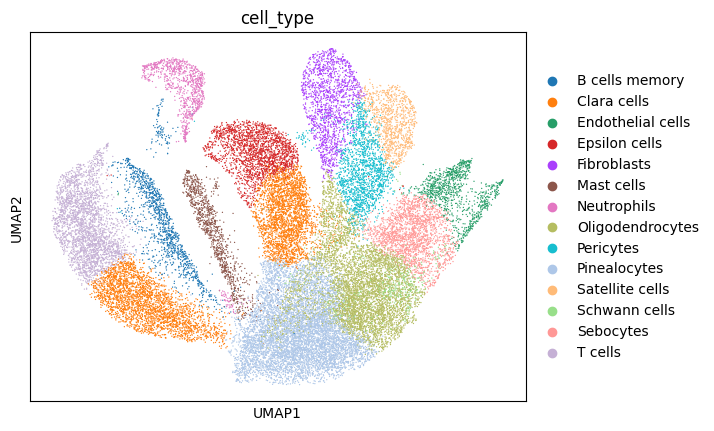

In [78]:
# Add cell type column based on annotation
data.obs['cell_type'] = [annotation_dict[clust] for clust in data.obs['leiden']]

# Visualize
sc.pl.umap(data, color='cell_type')

14 cell types have been identified and annotated  from the cell clusters

 We are going to use automatic prediction by assigning the top predicted cell type per cluster. However, manual inspection of each cell type gene expression require expertise to minimize errors

From the plot, the gene which is most  variable is MBD6

In [86]:
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [84]:
# # Compute a custom embedding (e.g., UMAP)
# sc.tl.umap(data,n_components=9)
# # Visualize cells in the UMAP space
# sc.pl.embedding(data, basis='umap', color='leiden')

In [85]:
# import numpy as np
# import seaborn as sns
# np.random.seed(42)
# data.obs['condition'] = np.random.choice(['healthy', 'tumor'], size=len(data))

# # Compute UMAP embedding
# sc.tl.umap(data)

# # Visualize the density of cells in the UMAP embedding per condition
# sc.pl.embedding_density(data, basis='umap', key='condition', cmap=sns.color_palette("Set2", as_cmap=True))

# plt.show()

In [82]:
data.obs

batch   label  n_genes_by_counts  total_counts  \
AAACCCAAGTCAGGGT-1-0     0  Normal               3987   -157.819290   
AAACCCACATCACAGT-1-0     0  Normal               3987   -171.680038   
AAACCCATCTCAATCT-1-0     0  Normal               3987    -78.637306   
AAACGAACAAGTTCGT-1-0     0  Normal               3987   -181.321426   
AAACGAATCTACCCAC-1-0     0  Normal               3987   -114.445480   
...                    ...     ...                ...           ...   
TTTGATCTCCCAGCGA-1-6     6   Tumor               3987   -241.009308   
TTTGATCTCTAGACAC-1-6     6   Tumor               3987   -260.339417   
TTTGTTGAGGGCATGT-1-6     6   Tumor               3987   -162.703156   
TTTGTTGAGGTAATCA-1-6     6   Tumor               3987   -288.874451   
TTTGTTGGTCCGGACT-1-6     6   Tumor               3987   -159.916412   

                      total_counts_mt  pct_counts_mt clusters leiden  \
AAACCCAAGTCAGGGT-1-0              0.0           -0.0        9      9   
AAACCCACATCACAGT-1-0              0.0           -0.0       14     14   
AAACCCATCTCAATCT-1-0              0.0           -0.0       18     18   
AAACGAACAAGTTCGT-1-0              0.0           -0.0       17     17   
AAACGAATCTACCCAC-1-0              0.0           -0.0       14     14   
...                               ...            ...      ...    ...   
TTTGATCTCCCAGCGA-1-6              0.0           -0.0       11     11   
TTTGATCTCTAGACAC-1-6              0.0           -0.0        2      2   
TTTGTTGAGGGCATGT-1-6              0.0           -0.0        4      4   
TTTGTTGAGGTAATCA-1-6              0.0           -0.0        2      2   
TTTGTTGGTCCGGACT-1-6              0.0           -0.0        4      4   

                              cell_type  
AAACCCAAGTCAGGGT-1-0          Pericytes  
AAACCCACATCACAGT-1-0    Satellite cells  
AAACCCATCTCAATCT-1-0  Endothelial cells  
AAACGAACAAGTTCGT-1-0      Schwann cells  
AAACGAATCTACCCAC-1-0    Satellite cells  
...                                 ...  
TTTGATCTCCCAGCGA-1-6   Oligodendrocytes  
TTTGATCTCTAGACAC-1-6        Clara cells  
TTTGTTGAGGGCATGT-1-6        Clara cells  
TTTGTTGAGGTAATCA-1-6        Clara cells  
TTTGTTGGTCCGGACT-1-6        Clara cells  

[33434 rows x 9 columns]

## Clustering of  cell types
Leiden algorithm was be used for hierarchical clustering, allowing for to discover and characterize cell types or states within a heterogeneous sample. We will compare tSNE and UMAP clustering to see which one provides more reasonale clusteers. In each case we will use PCAs of 9.

In [ ]:
# sc.pp.neighbors(data,n_pcs=8)
# sc.tl.umap(data,n_components=8)
# # sc.tl.leiden(data, key_added="clusters")

In [ ]:
# sc.tl.leiden(data)

In [ ]:
# sc.pl.umap(data, color=['leiden'], legend_fontsize=8)
data

# Ranking genes per cell type

In [87]:
# Extracting top 1500 genes
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)
top_1500Genes

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
# Cell type by condition/label
sc.pl.umap(
    data,
    color=["label", "cell_type"],
    frameon=False,
    ncols=2,
)

We can again see 19 clusters from UMAP clustering. However, the tSNE seems to be giving cleaer distictness among the clusters. In the next steps, we are going to unpack each category to determine which genes are differentially expressed in the cell categories.

In [ ]:
# top_markers_names

In [88]:
import scanpy as sc
import pandas as pd
from matplotlib import rcParams
sc.tl.rank_genes_groups(data, 'leiden', method='t-test')
# The head function returns the top n genes per cluster
top_markers = pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)
top_markers_names = data.obs["cell_type"]

# print(top_markers)
top_markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: 

0           1          2        3           4         5           6  \
0     CTSV  AC015712.2       GZMM     CD28      MIPOL1  HIST1H3A    IGKV3-20   
1    KRT6A        PI15  LINC00861   GIMAP2       KIF1A     GSTA1     IGKV4-1   
2  CYP24A1     CYP24A1      PLAC8  SLFN12L  AC097059.1  Z93241.1     IGHV3-7   
3    PTPRB       KRT6A     GIMAP2   SH2D2A        DTNA   C5orf46  AL117339.4   
4      KDR     FAM237B      CXCR3      SPN     SCGB2A1   FAM237B    KRTAP2-3   

            7        8       9       10      11         12      13  \
0        DTNA    DEFB1   EDNRA    SPON2   EDNRA      CD79B  GCSAML   
1      MIPOL1    KRT6A   SGIP1  COL14A1   PRKG1      BANK1   MS4A2   
2  AC097059.1  CYP24A1  COL5A3     RCN3   SGIP1  TNFRSF13C   RGS13   
3       HMGB3     CTSV    RCN3    FBLN2  COL5A3   HLA-DRB5    LAX1   
4     MICALL2    PTPRB   PRKG1      DPT   KCNE4    HLA-DMB  ADGRE2   

           14      15       16          17      18      19  
0         HGF    SPI1  CYP24A1      PCAT19  PCAT19    GBP5  
1       SNAI2   ITGAX    DEFB1       OLFM1    CDH5    CD28  
2        IGF1  PLA2G7     SOX7        DLL4    LMO2   SKAP1  
3  AC022509.2   C5AR1    KRT6A  AL591846.2    RHOJ  GPR155  
4       RSPO3  SLAMF7     CTSV        HES5    ESAM   ITGAL

# Top Marker genes by cluster
The top gene per category of cells have been extracted for spatial analysis i.e to get the patterns of tgeir distribution in other cells. From the results of the marker gene extraction after log nomalization and quakity control, CTSL gene is the most variable gene across the cell types.

## steps
- Obtain highly variable genes
- Rank the genes in order of counts
- Cluster the genes into distinct groups
- Rank the genes in each cluster


In [89]:
top_genes_list = []

# Iterate over the columns (categories) of the DataFrame
for col in top_markers.columns:
    # Extract the top genes for the current category and convert them to a list
    top_genes_sublist = top_markers[col].tolist()[0]
    
    # Append the sublist of top genes to the main list
    top_genes_list.append(top_genes_sublist)
# top_genes_list.insert(13,"KRT8") # check confirmation from literature of co-experession between KRT8 and KRT18
# Print the list of lists
top_genes_list

['CTSV',
 'AC015712.2',
 'GZMM',
 'CD28',
 'MIPOL1',
 'HIST1H3A',
 'IGKV3-20',
 'DTNA',
 'DEFB1',
 'EDNRA',
 'SPON2',
 'EDNRA',
 'CD79B',
 'GCSAML',
 'HGF',
 'SPI1',
 'CYP24A1',
 'PCAT19',
 'PCAT19',
 'GBP5']

In [90]:
marker_genes = list(set(top_genes_list))
list(annotation_dict.values())

['Oligodendrocytes',
 'Pinealocytes',
 'Fibroblasts',
 'Oligodendrocytes',
 'B cells memory',
 'Mast cells',
 'Satellite cells',
 'Neutrophils',
 'Endothelial cells',
 'Schwann cells',
 'Endothelial cells',
 'T cells',
 'Clara cells',
 'T cells',
 'Clara cells',
 'Pinealocytes',
 'Pinealocytes',
 'Epsilon cells',
 'Sebocytes',
 'Pericytes']

In [91]:
marker_genes

['CD28',
 'AC015712.2',
 'SPON2',
 'HGF',
 'GZMM',
 'GCSAML',
 'CD79B',
 'CYP24A1',
 'PCAT19',
 'SPI1',
 'MIPOL1',
 'IGKV3-20',
 'EDNRA',
 'GBP5',
 'HIST1H3A',
 'CTSV',
 'DEFB1',
 'DTNA']

In [ ]:
# # Marker genes per cluster
# ax = sc.pl.stacked_violin(data, marker_genes, groupby='leiden',
#                          var_group_positions=[(7, 8)], var_group_labels=['T cells'])

Genes such as CTSL are expressed in more than one type of cells in clusters 12, 10, 1 and 0. We can visualize the gene clustering using a dot plot with a dendrogram
to show the relatedness and level of the gene expression across different cells as shown below. Track plot also shows the gene expression profiles using baar graphs as shown below.

    using 'X_pca' with n_pcs = 8
Storing dendrogram info using `.uns['dendrogram_leiden']`


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


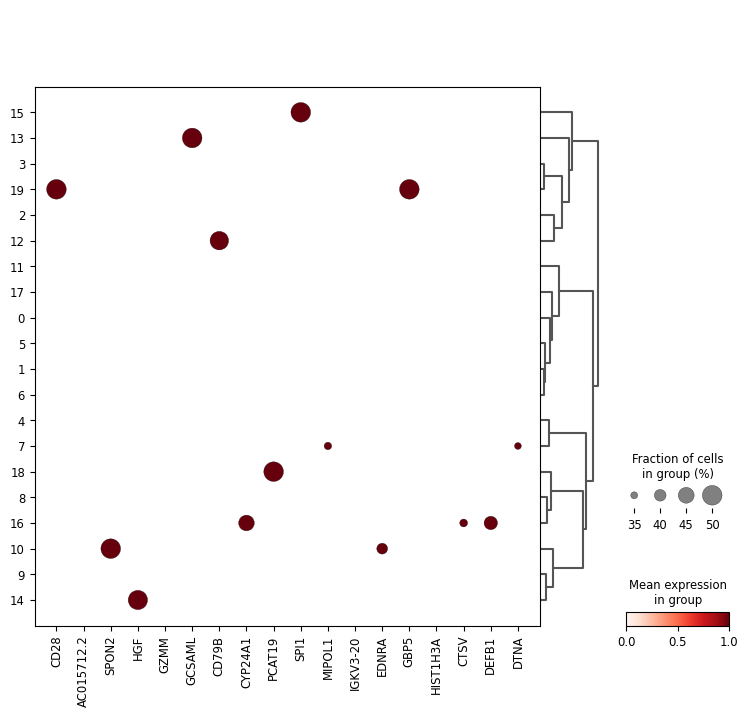

In [92]:
ax = sc.pl.dotplot(data, marker_genes, groupby='leiden', dendrogram=True, dot_max=0.5, dot_min=0.3, standard_scale='var')

From the dot plot and using the top selected genes per cluster, expression patterns in clusters 8 and 9 are closer than other expression patterns. Also, classes 2 and 10 are closely related in their expression patterns.  Among the cell types, CTSL is the highest expressed in all the six cell types. AREG gene is highly expressed in two cell types for clusters 9 and 5. The output also suggests co-expression patterns for KRT8 and KRT18. This is evident by the fact that clusters that show differential expression for the AREG gene also have differential expression of the KRT18 gene. Some genes are also shown to be interrelated and may be involved in similar metabolic pathways. For example. In cluster 11, CTSL, SRGN, and HLA-DQA1 are highly expressed and their overexpressed seems to cause the underexpression of AREG, TNFA1P6, and CXCR4. 



# Cell types based on marker genes

To annotate single cell clusters, we can use cell type specific marker genes. These are genes that are mainly expressed exclusively by a specific cell type, making them useful to distinguish heterogeneous groups of cells. Marker genes were discovered and annotated in previous studies and there are some resources that collect and curate them.

Omnipath is one of the largest available databases of curated prior knowledge. Among its resources, there is PanglaoDB, a database of cell type markers, which can be easily accessed using a wrapper to Omnipath from decoupler.

We can use the marker gene to identify the cell types. These marker genes were obtained from the literature.

# Track plots
Track plots is another way of visualizing expression patterns of genes per cell type

In [93]:
# Track plot data is better visualized using the non-log counts
import numpy as np
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

/tmp/ipykernel_4635/3075314540.py:4: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  ad.raw.X.data = np.exp(ad.raw.X.data)


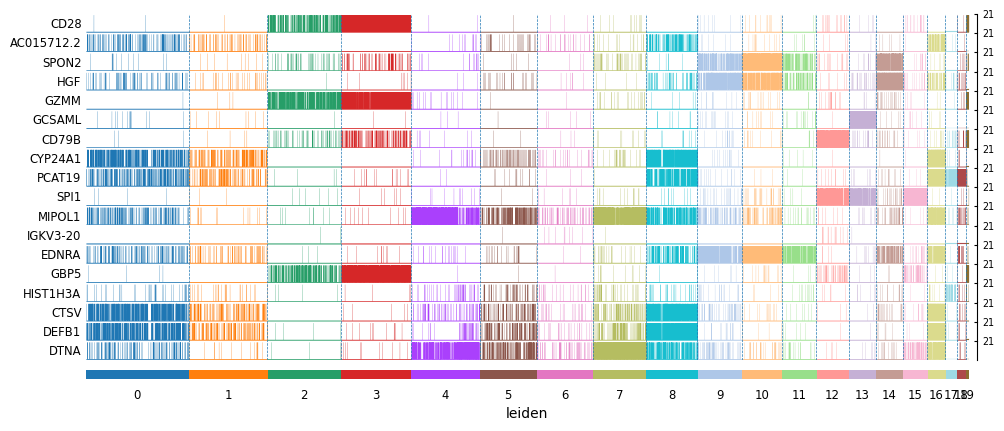

In [94]:
ax = sc.pl.tracksplot(ad,marker_genes, groupby='leiden')

 We can see similar expression patterns in clusster 6  and 7 . These clusters show similar density pattens

# Marker gene Visualization

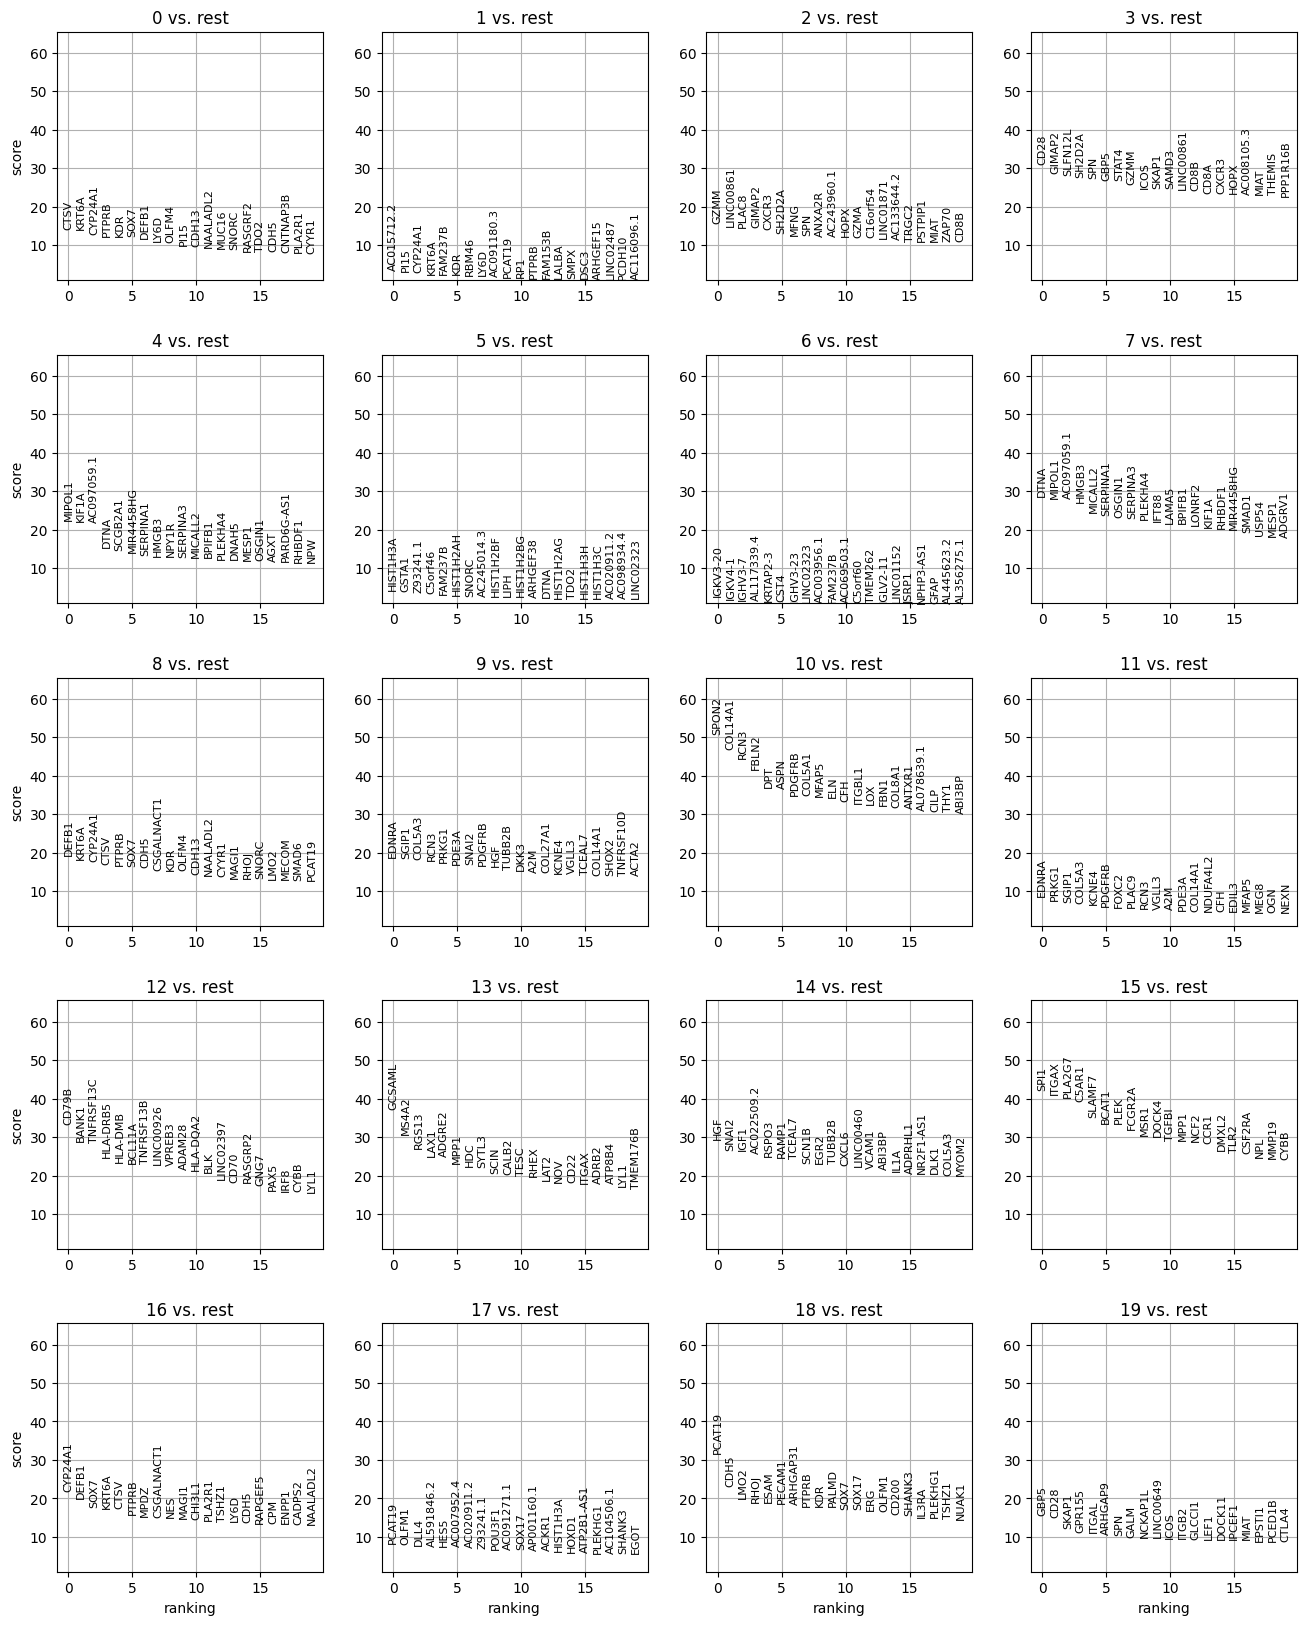

In [95]:
#v one vs rest visualization
rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(data)

Among the top cell-specific expressed genes are 'CTSL', 'GEM', 'PLCG2', 'DCN', 'AREG', 'SPINT2', 'PLCG2', 'KRT7', 'KRT18', 'HLA-C', 'GSTO1', 'IGFBP7', 'RPS27',
'KRT8'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


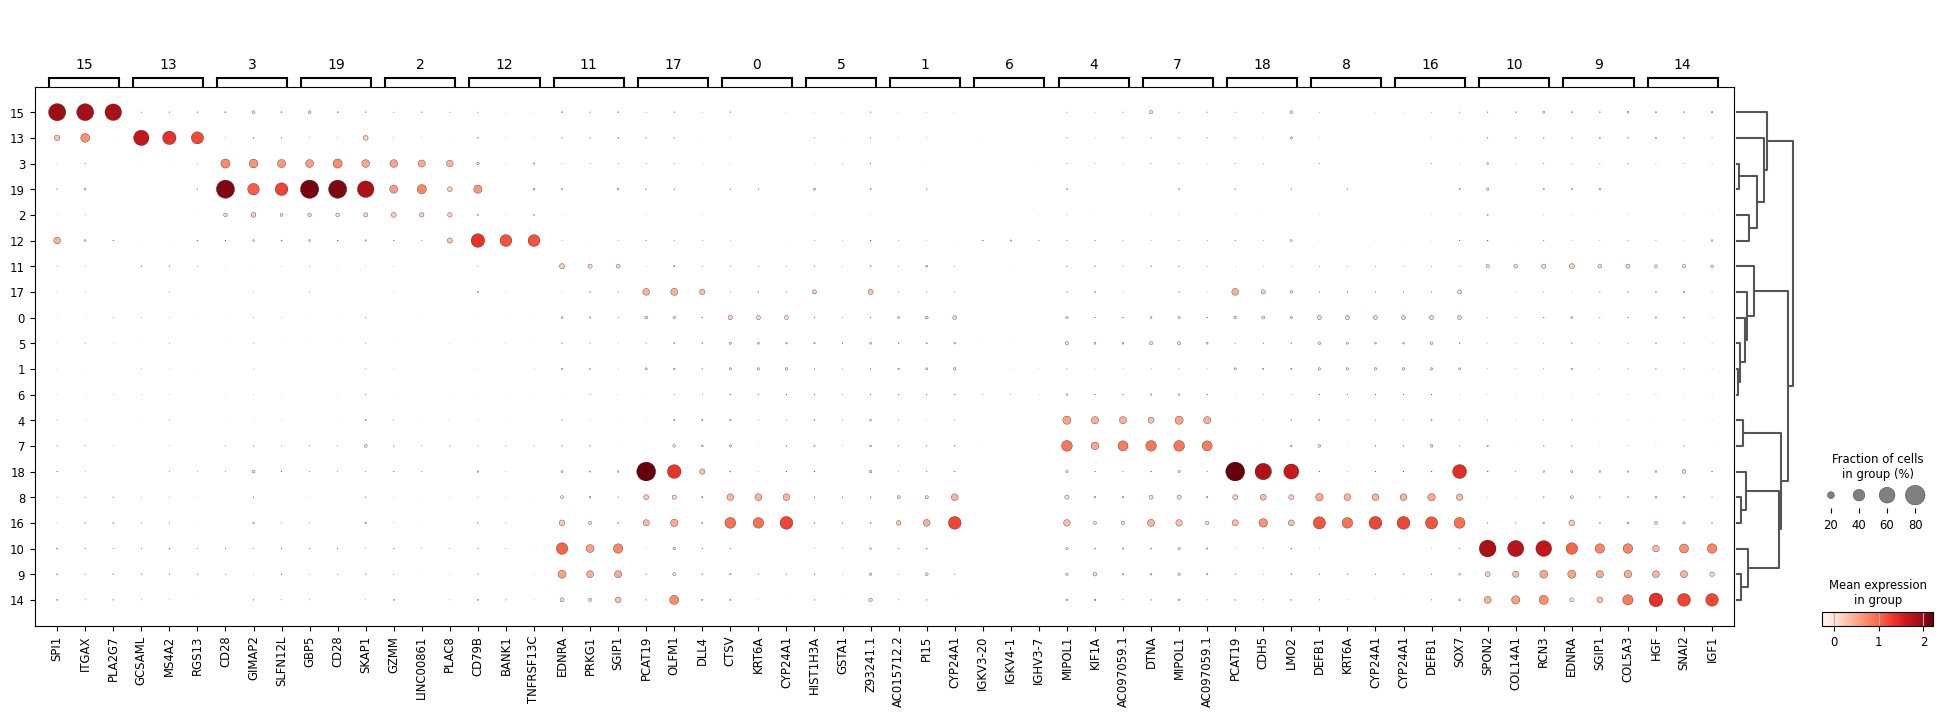

In [96]:
sc.pl.rank_genes_groups_dotplot(data, n_genes=3)

Plot showing top 4 gene expression patterns per cell category. For example, cluser 6 and 2 show similar expression patterns for gene MALAT 1 Cluster 7 and Cluster 6 show closely related expression patterns for the differentially expressed genes. There is evidence for co-expression patterns in genes such as IGFBP7 and FI27 in cluster 11. The MALAT1 gene has overexpression patterns in cell types 2 and 6

# Heat Map for differentially exprssed genes per  cell type category

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: 

    using 'X_pca' with n_pcs = 8
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 5


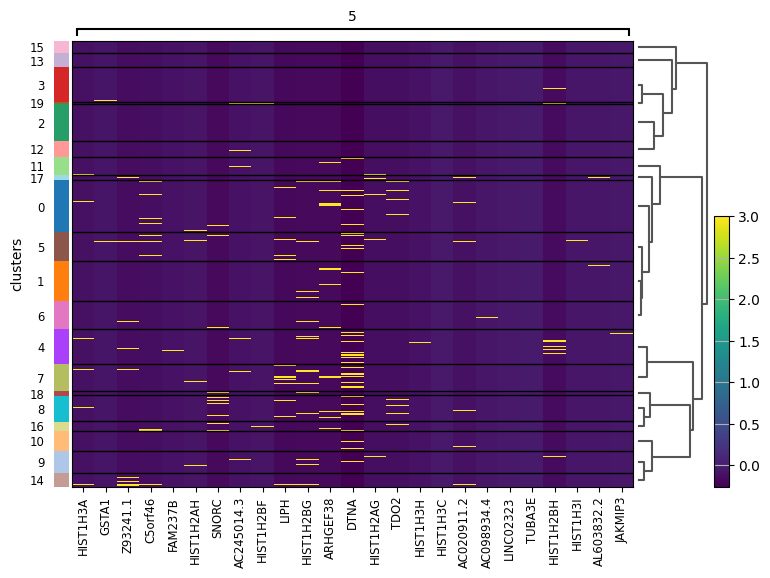

In [97]:
sc.tl.rank_genes_groups(data, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(data, groups="5", n_genes=25, groupby="clusters")

S1006A stands out as the most overexpressed gene in most of the cell types. Clusers 4 and 11 show the highest differentially expressed genes

## Pathway Analysis


Let’s extract the ranks for genes differentially expressed in cluster 0. We use these ranks and the gene sets from REACTOME to find gene sets enriched in this cell population compared to all other populations using GSEA as implemented in decoupler.

In [4]:
data2= sc.read_h5ad("../data/modified_data.h5ad")
data2

AnnData object with n_obs × n_vars = 39591 × 33538
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
data2.obs

batch
AAACCCAAGTCAGGGT-1-0     0
AAACCCACATCACAGT-1-0     0
AAACCCATCTCAATCT-1-0     0
AAACGAACAAGTTCGT-1-0     0
AAACGAACACAACGAG-1-0     0
...                    ...
TTTGATCTCTAGACAC-1-6     6
TTTGGTTGTTCCTAAG-1-6     6
TTTGTTGAGGGCATGT-1-6     6
TTTGTTGAGGTAATCA-1-6     6
TTTGTTGGTCCGGACT-1-6     6

[39591 rows x 1 columns]

We will define a function to get differentially expressed genes in each cell type vs the rest. We will then call the function and pass in the cluster of the cell category to obtain the sorted ranks of genes in order of differential expression 

In [6]:
# Storing the counts for later use
data2.layers["counts"] = data2.X.copy()
# Renaming label to condition
data2.obs = data2.obs.rename({"label": "condition"}, axis=1)

# Normalizing
sc.pp.normalize_total(data2)
sc.pp.log1p(data2)

normalizing counts per cell
    finished (0:00:00)


In [7]:
top_4000Genes=sc.pp.highly_variable_genes(data2, flavor="seurat", n_top_genes=4000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [8]:
sc.pp.pca(data2)
sc.pp.neighbors(data2)
sc.tl.umap(data2)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:26)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:26)


In [9]:
# adata.obs["group"] = data2.obs.("string") + "_" + adata.obs.cell_type

In [12]:
def get_scores(cluster):
    # Perform differential expression testing with the desired method ('t-test')
    scores = pd.DataFrame(data2.uns['rank_genes_groups']['scores'])[cluster]
    gene_names = pd.DataFrame(data2.uns['rank_genes_groups']['names'])[cluster]
    # Create a DataFrame with gene names in the first column and scores in the second column
    top_markers = pd.DataFrame({'Gene Names': gene_names, 'Scores': scores})
    
    # sort the DataFrame by absolute scores
    markers = top_markers.iloc[np.abs(top_markers['Scores']).argsort()[::-1]]
    markers=markers.set_index('Gene Names', inplace=True)
    return markers

## Gene ranks for cluster 0

In [13]:
cluster_0=get_scores("0").head(1500)
cluster_0

KeyError: 'rank_genes_groups'

Now we will use the python package decoupler [Badia-i-Mompel et al., 2022] to perform GSEA enrichment tests on our data.

## Retrieve gene sets
Download and read the gmt file for the REACTOME pathways annotated in the C2 collection of MSigDB.

In [ ]:
# # Downloading reactome pathways
from pathlib import Path

# if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
#     !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [ ]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [ ]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")
reactome
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]
reactome

## Running GSEA
We will read the gene sets first. Unlike packages like fgsea that automatically filter gene sets based on maximum size, decoupler, by default, does not perform such filtering. Instead, we will manually screen gene sets, ensuring they contain a minimum of 15 genes and a maximum of 500 genes.

In [ ]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

We’ll use the t-statistics from the t-test to rank the genes for the cluster 0 and computes p-values for each of the pathways.

In [ ]:
def pathway_enrichment(cluster):
    # Extract the scores of the differentially expressed genes
    cluster_df=get_scores(cluster).head(4000)
    # print(cluster_df)
    # Run the GSEA using the reactom database
    scores, norm, pvals = decoupler.run_gsea(
        cluster_df.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",)
    # Get t-stat
    gsea_results = pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1).droplevel(level=1, axis=1).sort_values("pval")
    print(gsea_results)
    return gsea_results

In [ ]:
%%time
cluster_0=pathway_enrichment("0")
cluster_0

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


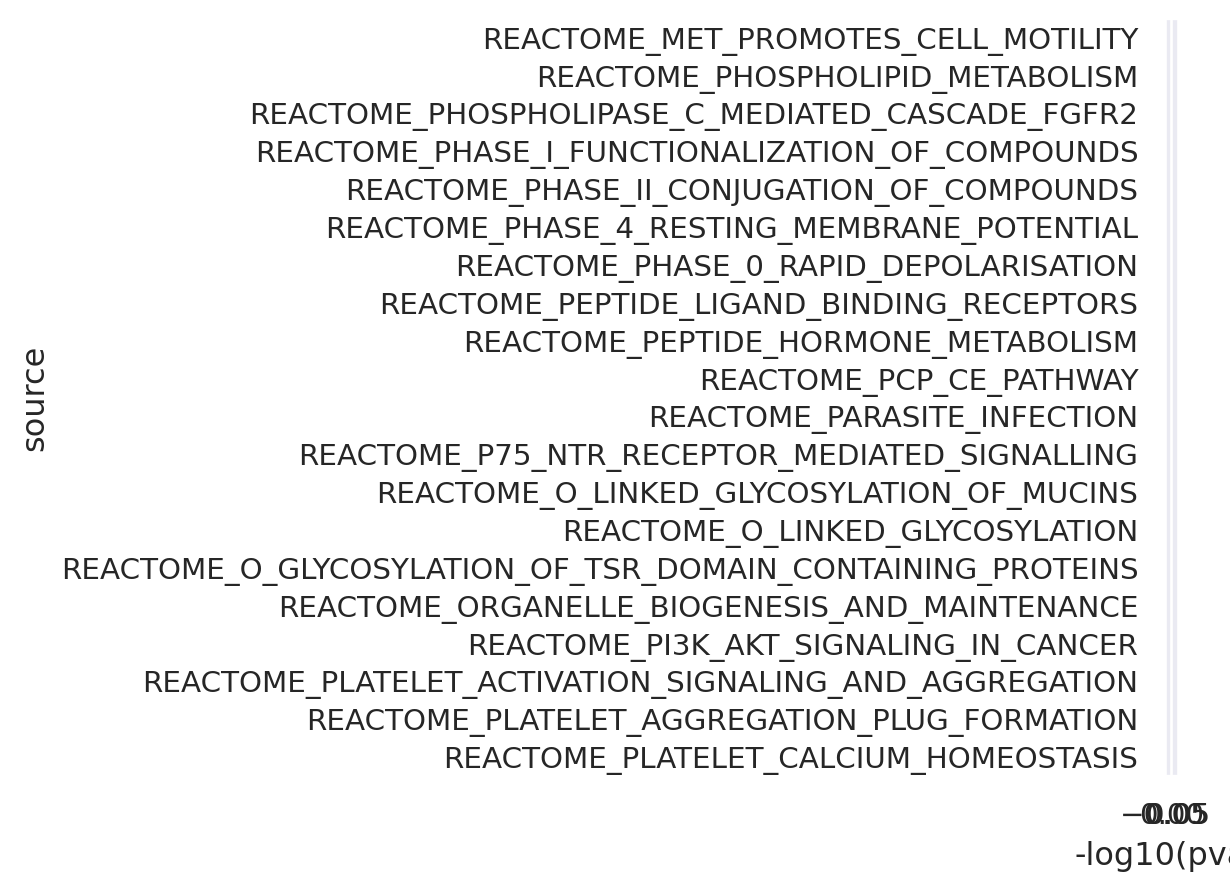

In [157]:
(
    so.Plot(
        data=(
            cluster_0.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [ ]:
cluster_0.head(50).pval

We make a bar plot of top 20 pathways significantly enriched in stimulated cluster 0 cells

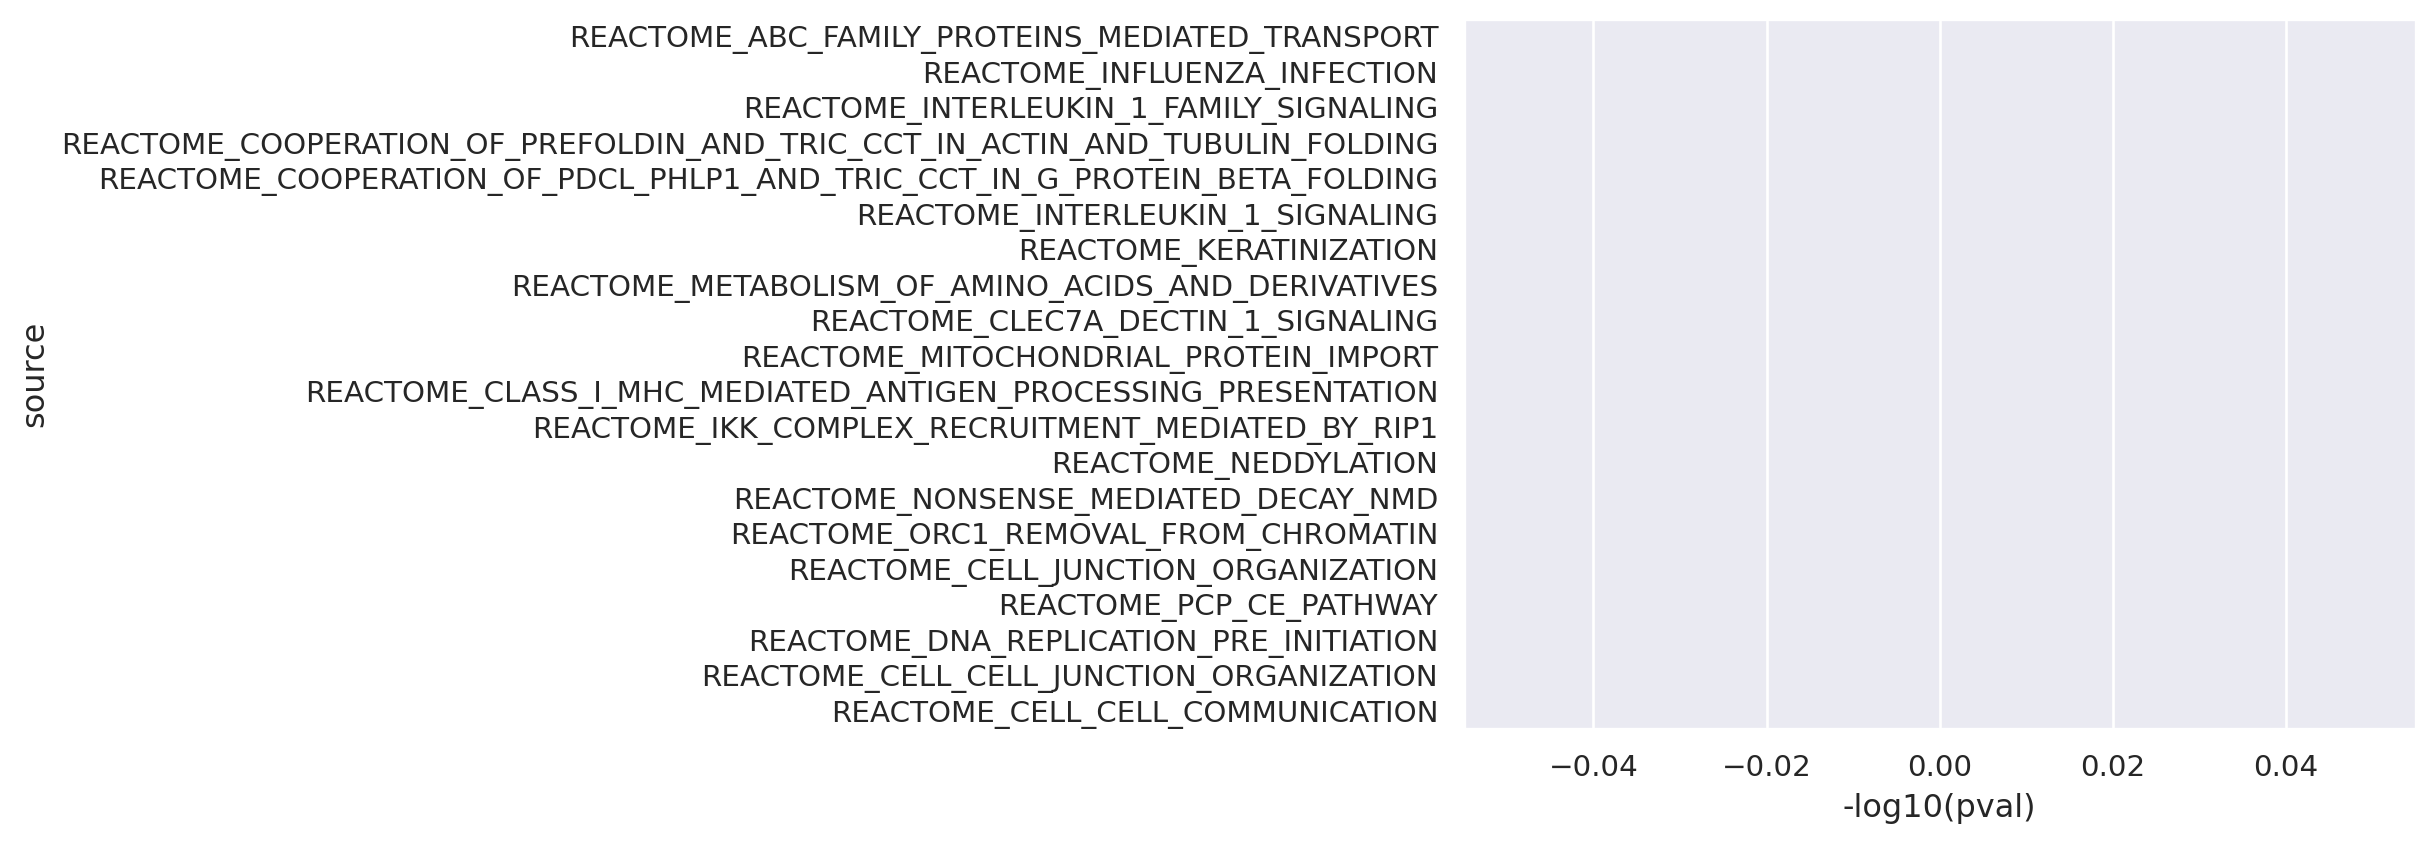

In [247]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [ ]:
# Cluster 1
get_t_statistics("1")

In [ ]:
# Cluster 1
get_t_statistics("2")

In [ ]:
# Cluster 1
get_t_statistics("3")

In the  graph, the y-axis represents the names of pathways, while the x-axis illustrates the adjusted p-values. The greater the height of the bar, the more pronounced the significance of the pathway. The pathways are arranged in order of their level of significance.

In [231]:
reactome=reactome["genesymbol"].to_list()

In [233]:
reactome.index("CTSL")

3446

# Results and Discussion
- Cathepsin L (CTSL), is a lysosomal acid cysteine protease that has been reported to play a critical role in chemosensitivity and tumor progression. I has been found that CTSL served as a prognostic marker for poor clinical outcomes in Neuroblastoma patients [4] and breat cancer [5].
-  AREG has ben suggested as a valuable prognostic biomarker in invasive breast cancer and promising therapeutic targets, especially in ER-negative breast cancer [6]
- The study suggests co-expresion patterns of KRT8 and KRT 18 genes 8, 5 and 9. Previous studies have shown the co-expression of these genes in cancer breat patients [7].
- The expression of the HLA-DQA1 significantly upregulated in breast cancer a sin line with the previous findings [8].
-  IGFBP7 was reported to play tumor suppressive role in breast cancer[9]

# Conclusion
- This project has shown the co-expression pattersn for KRT8 and KRT 18 genes genes
- Most cancer associated genes are CTSL,AREG  and DCN

# References
https://tcr.amegroups.org/article/view/76142/html

1. Kim H, Whitman AA, Wisniewska K, Kakati RT, Garcia-Recio S, Calhoun BC, Franco HL, Perou CM, Spanheimer PM. Tamoxifen Response at Single Cell Resolution in Estrogen Receptor-Positive Primary Human Breast Tumors. bioRxiv [Preprint]. 2023 Apr 19:2023.04.01.535159. doi: 10.1101/2023.04.01.535159. Update in: Clin Cancer Res. 2023 Sep 25;: PMID: 37066379; PMCID: PMC10103953.
2. Wei Z, Shen Y, Zhou C, Cao Y, Deng H, Shen Z. CD3D: a prognostic biomarker associated with immune infiltration and immunotherapeutic response in head and neck squamous cell carcinoma. Bioengineered. 2022 May;13(5):13784-13800. doi: 10.1080/21655979.2022.2084254. PMID: 35712757; PMCID: PMC9276048.
3. Lu, J., Ahmad, R., Nguyen, T. et al. Heterogeneity and transcriptome changes of human CD8+ T cells across nine decades of life. Nat Commun 13, 5128 (2022). https://doi.org/10.1038/s41467-022-32869-x
4. Du, X., Ding, L., Huang, S., Li, F., Yan, Y., Tang, R., ... & Wang, W. (2022). Cathepsin L promotes chemresistance to neuroblastoma by modulating serglycin. Frontiers in Pharmacology, 13, 920022.
5. Zhang, L., Zhao, Y., Yang, J., Zhu, Y., Li, T., Liu, X., ... & Fu, J. (2023). CTSL, a prognostic marker of breast cancer, that promotes proliferation, migration, and invasion in cells in triple-negative breast cancer. Frontiers in Oncology, 13, 1158087.
6. Xiang, G., Liu, F., Liu, J., Meng, Q., Li, N., & Niu, Y. (2019). Prognostic role of Amphiregulin and the correlation with androgen receptor in invasive breast cancer. Pathology-Research and Practice, 215(6), 152414.
7. Wilson, C. A., & Dering, J. (2004). Recent translational research: microarray expression profiling of breast cancer–beyond classification and prognostic markers?. Breast Cancer Research, 6, 1-9.
8. Wu, G., Xiao, G., Yan, Y., Guo, C., Hu, N., & Shen, S. (2022). Bioinformatics analysis of the clinical significance of HLA class II in breast cancer. Medicine, 101(40).
9. Li, D., Xia, L., Huang, P., Wang, Z., Guo, Q., Huang, C., ... & Qin, S. (2023). Cancer-associated fibroblast-secreted IGFBP7 promotes gastric cancer by enhancing tumor associated macrophage infiltration via FGF2/FGFR1/PI3K/AKT axis. Cell Death Discovery, 9(1), 17.
10. https://www.sc-best-practices.org/introduction/analysis_tools.html
11. https://www.sc-best-practices.org/conditions/gsea_pathway.html
12. https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

1. RCN3 is highly expressed in most tumors, and it is associated with poor prognosis[1]
2. PLAC8 promotes adriamycin resistance via blocking autophagy in breast cancer[2]
3.  NCKAP1 is a tumor suppress gene. In breast cancer, NCKAP1 is highly expressed[3]
4. COL14A1 was found to be down-regulated in most of breat cancer cells[4]
5. MIPOL1 is thought to act as a tumor suppressor, and its fusions may accompany ETV1 fusions[5]
6. Spondin-2 (SPON2) has been reported to be involved in metastasis
and cancer progression[6]

1. Ding, J., Meng, Y., Han, Z., Luo, X., Guo, X., Li, Y., ... & Zhuang, K. (2022). Pan-cancer analysis of the oncogenic and immunological role of RCN3: a potential biomarker for prognosis and immunotherapy. Frontiers in Oncology, 12, 811567.
2. Chen, Y., Jia, Y., Mao, M., Gu, Y., Xu, C., Yang, J., ... & Wang, L. (2021). PLAC8 promotes adriamycin resistance via blocking autophagy in breast cancer. Journal of Cellular and Molecular Medicine, 25(14), 6948-6962.
3. Zhong, X. P., Kan, A., Ling, Y. H., Lu, L. H., Mei, J., Wei, W., ... & Guo, R. P. (2019). NCKAP1 improves patient outcome and inhibits cell growth by enhancing Rb1/p53 activation in hepatocellular carcinoma. Cell death & disease, 10(5), 369.
4. Malvia, S., Chintamani, C., Sarin, R., Dubey, U. S., Saxena, S., & Bagadi, S. A. R. (2023). Aberrant expression of COL14A1, CELRS3, and CTHRC1 in breast cancer сells. Experimental Oncology, 45(1), 28-43.
5. Maher CA, Kumar-Sinha C, Cao X, Kalyana-Sundaram S, Han B, Jing X, et al. Transcriptome sequencing to detect gene fusions in cancer. Nature. 2009;458:97–101.
6. Wu, M., Kong, D., & Zhang, Y. (2023). SPON2 promotes the bone metastasis of lung adenocarcinoma via activation of the NF-κB signaling pathway. Bone, 167, 116630.